# Aftab Khalil - 19837
## Datascience Product development - Project phase 3
<hr/>

<h2><u>Convolutional Neural Network:</u></h2>
<br>
<center><i>"In deep learning, a convolutional neural network (<b>CNN</b>, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imager. The name “convolutional neural network” indicates that the network employs a mathematical operation called convolution. Convolutional networks are a specialized type of neural networks that use convolution in place of general matrix multiplication in at least one of their layer"</i></center>
<br>(source : <a href="https://en.wikipedia.org/wiki/Convolutional_neural_network" target="_blank">https://en.wikipedia.org/wiki/Convolutional_neural_network</a>)
<hr>

<h2><u>Pictorial representation</u></h2>
<br>
<img src="https://miro.medium.com/max/1250/1*vkQ0hXDaQv57sALXAJquxA.jpeg" style="border : 1px solid black; padding : 20px;"/>
<hr>
<hr>

<h1>Imports</h1>

In [1]:
import os
import librosa
import numpy as np
import scipy.signal as sps

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

<h1>Global values</h1>

In [2]:
sample_rate = 16000
audio_size = 8000
train_audio_path = "../../data"
labels = os.listdir(train_audio_path)
print(labels)

#Hard coding classes here, in case we dont want to read data again and again this list will be used simply
classes = ["bed", "bird", "cat", "dog", "down", "eight", "five", "four", "go", "happy", "house", "left", "marvin", "nine", "no", "off", "on", "one", "right", "seven", "sheila", "six", "stop", "three", "tree", "two", "up", "wow", "yes", "zero"]

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


<h1>Reading data and resizeing</h1>
<p>We read all data and resize them to one size, if some one fails to resize we simply ignore it, sixe by side we print the number of datapoints that got resized successfully.<p>

In [3]:
all_wave = []
all_label = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    r = 0
    for wav in waves:
        try:
            sample, _ = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = sample_rate)
            sample = sps.resample(sample, audio_size)
            if(len(sample) == audio_size) : 
                r += 1
                all_wave.append(sample)
                all_label.append(label)
        except:
            pass
    print(f'{label}:{r}')

bed:1713
bird:1731
cat:1733
dog:1746
down:2359
eight:2352
five:2357
four:2372
go:2372
happy:1742
house:1750
left:2353
marvin:1746
nine:2364
no:2375
off:2357
on:2367
one:2370
right:2367
seven:2377
sheila:1734
six:2369
stop:2380
three:2356
tree:1733
two:2373
up:2375
wow:1745
yes:2377
zero:2376


<h1>Classes</h1>
<p>Here we read classes from data, and make a categorical label for each class.</p>

In [4]:
le = LabelEncoder()
y = le.fit_transform(all_label)
y = np_utils.to_categorical(y, num_classes = len(classes))
classes = list(le.classes_)
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


<h1>Splitting data into test and train</h1>

In [5]:
all_wave = np.array(all_wave).reshape(-1, audio_size, 1)

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(all_wave), np.array(y), stratify = y, test_size = 0.2, random_state = 777, shuffle = True)

<h1>Defining the CNN Model</h1>
<p>We are using <a href="https://en.wikipedia.org/wiki/Convolutional_neural_network" target="_blank">CNN</a> model for training  upon data to predict labels</p>

In [7]:
K.clear_session()

def create_model():
    inputs = Input(shape=(audio_size, 1))
    
    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    #Flatten layer
    conv = Flatten()(conv)
    
    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    
    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    
    outputs = Dense(len(classes), activation='softmax')(conv)
    
    model = Model(inputs, outputs)
    return model

<h1>Train Model</h1>
<p>This funtion trains and returns the model, and have an optional argument <b>from_scratch</b> if set to true, it will train the model from scratch or elsewise will use the already avaible model to retrain and return, by default it is set to false</p>

In [8]:
def train_model(from_scratch = False):
    if(from_scratch or not os.path.exists('best_model.hdf5')):
        print('Creating model')
        model = create_model()
        print('Model created')
    else:
        print('Loading model')
        model = load_model('best_model.hdf5')
        print('Model loaded')
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, min_delta = 0.0001)
    mc = ModelCheckpoint('best_model.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
    model.fit(x_train, y_train , epochs = 100, callbacks = [es, mc], batch_size = 32, validation_data = (x_valid, y_valid))
    return model

<h1>Load Model</h1>
<p>This method simply returns the already trained model. <small style="color:red">(Throws error if no model found)</small></p>

In [9]:
def load_trainded_model():
    model = load_model('best_model.hdf5')
    print("Loaded trained model")
    return model

<h1>Get Model and Visualize it</h1>
<p>This method is responsible for generating the model and is exposed as api in .py file of docker container, it accepts the parameter <b>already_trained</b> if set to true it uses the already trained model else starts training the new one</p>

Loaded trained model


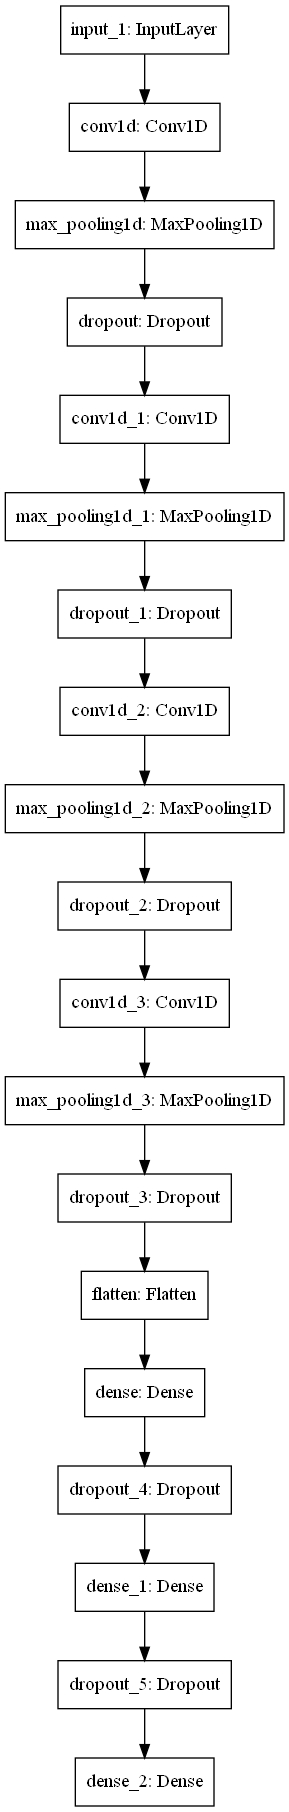

In [10]:
def get_model(already_trained = True):
    global model
    model =  load_trainded_model() if already_trained else train_model()

#Send false if want to retrain model
get_model()
plot_model(model, to_file='Model.png')

<h1>Predict Function</h1>
<p>This function inputs an array of float as audio and its sample rate and outputs the most likely value of it, it is also exposed as an api in docker.</p>

In [11]:
def predict(audio, sample_rate):
    prob = model.predict(audio.reshape(1, audio_size, 1))
    index = np.argmax(prob[0])
    return classes[index]

<h1>Lets predict!</h1>
<p>Here we simply try to predict an input<p>

In [12]:
audio, sample_rate = librosa.load('../../data/bird/00b01445_nohash_0.wav', sr = sample_rate)
audio = sps.resample(audio, audio_size)
print("Predicted Label:", predict(audio, sample_rate))

Predicted Label: bird


<hr>
<hr>

<h1>Model Accuracy</h1>

In [13]:
loss, accuraccy = model.evaluate(x_valid, y_valid, verbose=1)
print(f'Loss : {loss}, Accuraccy : {accuraccy}')

405/405 [==============================] - 17s 40ms/step - loss: 0.7004 - accuracy: 0.8012
Loss : 0.7003954648971558, Accuraccy : 0.8011587262153625


<h1>Per class classsification report</h1>

In [14]:
y_predict = model.predict(x_valid, verbose = 1)
y_predict_decoded = np.argmax(y_predict, axis = 1)
y_valid_decoded = np.argmax(y_valid, axis = 1)
report = classification_report(y_valid_decoded, y_predict_decoded)
print(report)

405/405 [==============================] - 15s 37ms/step
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       343
           1       0.74      0.82      0.78       346
           2       0.80      0.80      0.80       347
           3       0.82      0.68      0.75       349
           4       0.84      0.76      0.80       472
           5       0.79      0.87      0.83       470
           6       0.90      0.73      0.81       471
           7       0.74      0.83      0.78       475
           8       0.73      0.71      0.72       474
           9       0.90      0.90      0.90       348
          10       0.86      0.83      0.85       350
          11       0.83      0.78      0.81       471
          12       0.95      0.76      0.85       349
          13       0.80      0.84      0.82       473
          14       0.70      0.80      0.74       475
          15       0.80      0.82      0.81       471
          16       0.82 

In [15]:
print(f'From above results we can see that the best predicted class if no 27 i.e {classes[27]} and worst predicted class is 0 i.e {classes[0]}')

From above results we can see that the best predicted class if no 27 i.e wow and worst predicted class is 0 i.e bed


<h1>Confusion Matrix</h1>
<p>For our ease let us also present the findiangs with a confusion matrix</p>

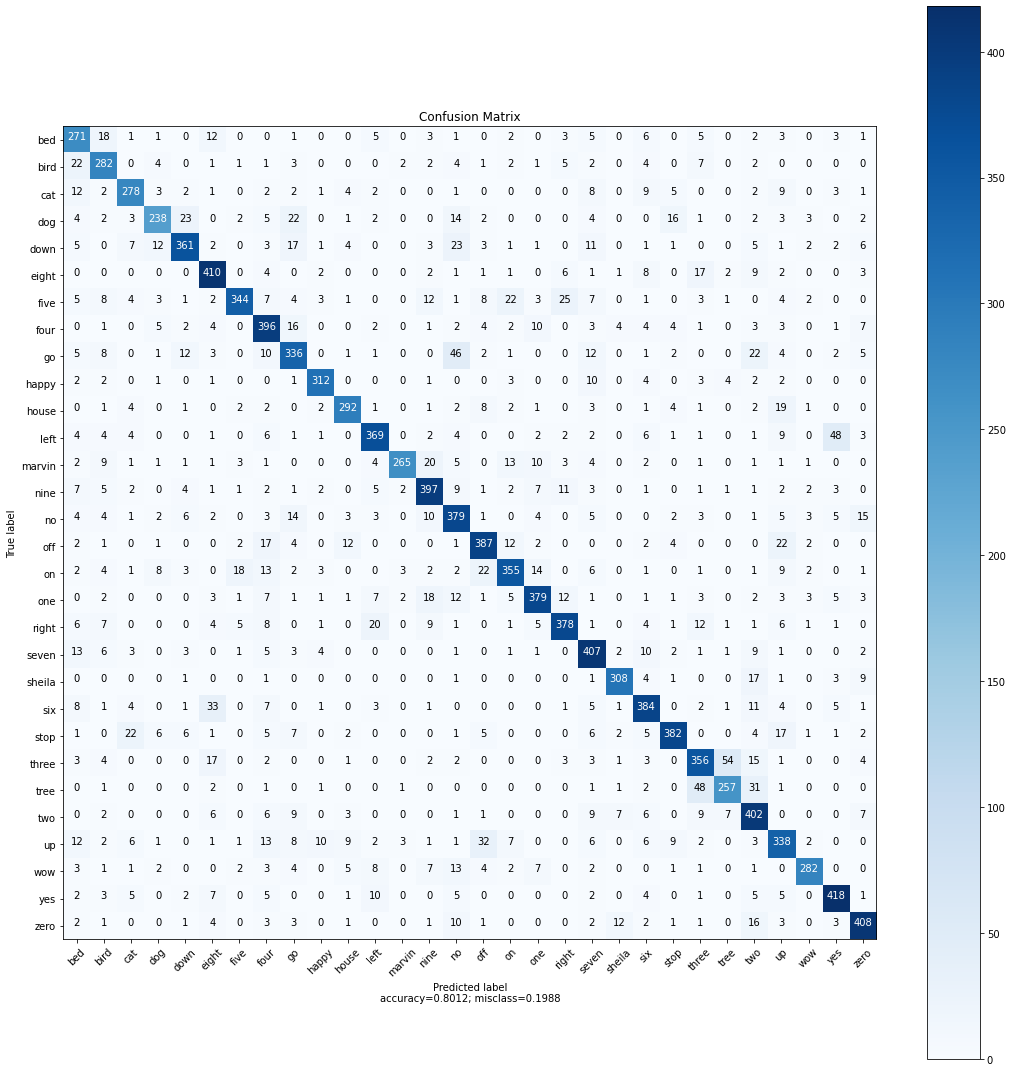

In [16]:
#Citiation :  https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Confusion matrix',
                          cmap = None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

cm = confusion_matrix(y_valid_decoded, y_predict_decoded)
plot_confusion_matrix(cm           = cm, 
                      target_names = classes,
                      title        = "Confusion Matrix")

<hr><hr>

<h1>End 🐍</h1>